In [1]:
from pathlib import Path
import torch.nn.functional as F
import matplotlib.pyplot as plt
import wandb

import sys

sys.path.append("/work")
from src.data.mnist import MNISTDataModule
from src.wandb.generate.train import WandbModule
from src.utils import torch_fix_seed

torch_fix_seed(42)

In [2]:
wandb.init(project="local_dev_run")
artifact = wandb.use_artifact("ishiyama-k/model-registry/Generate MNIST:latest")
artifact_dir = artifact.download()
checkpoint = Path(artifact_dir) / "model.ckpt"
module = WandbModule.load_from_checkpoint(checkpoint_path=checkpoint)
module = module.to("cuda")
module.eval()
print(module)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: ishiyama-k. Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


WandbModule(
  (model): GenerationAgents(
    (speaker): Speaker(
      (extractor): Monotone28(
        (cnn): Sequential(
          (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): ReLU()
          (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (4): ReLU()
          (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (transformer): TransformerDecoder(
        (layers): ModuleList(
          (0-2): 3 x TransformerDecoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (multihead_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (linear1): Linear

/home/user/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [3]:
dm = MNISTDataModule()
dm.prepare_data()
dm.setup(stage="test")

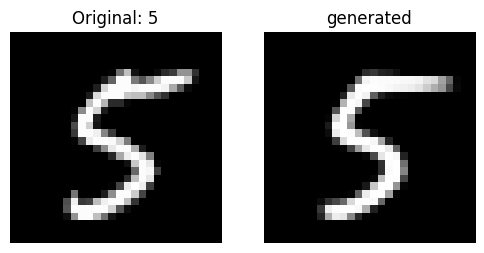

tokens: tensor([9, 2, 3, 2, 4, 6, 4, 8, 0, 9], device='cuda:0')


In [35]:
idx = 1
batch_idx = 1

current_batch_idx = 0
for batch in dm.test_dataloader():
    if current_batch_idx < batch_idx:
        current_batch_idx += 1
        continue

    X, Y = batch
    X, Y = X.to("cuda"), Y.to("cuda")
    X_hat, speaker_output, tokens_prob = module.model(X)
    x = X[idx].squeeze().cpu().numpy()
    x_hat = X_hat[idx].squeeze().detach().cpu().numpy()

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(x, cmap="gray")
    plt.axis("off")
    plt.title(f"Original: {Y[idx].item()}")

    plt.subplot(1, 2, 2)
    plt.imshow(x_hat, cmap="gray")
    plt.axis("off")
    plt.title(f"generated")
    plt.show()

    tokens = speaker_output[:,idx,:].argmax(dim=-1)
    print("tokens:", tokens)
    break

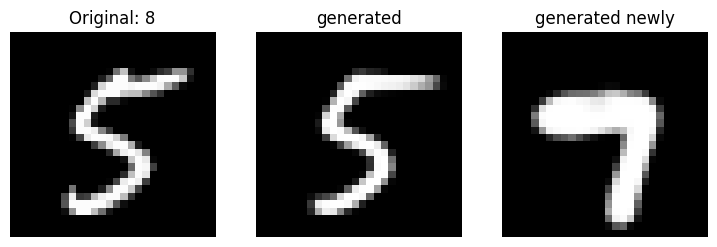

In [36]:
modified_tokens = tokens.clone()
modified_tokens[1] = 0

vocab_size = module.model.speaker.vocab_size -1
max_len = module.model.speaker.max_token_len
one_hot = F.one_hot(modified_tokens, num_classes=vocab_size)
one_hot = one_hot.view(max_len, 1, vocab_size)
new_X_hat = module.model.listener(one_hot)
new_X_hat = module.model.image_generator(new_X_hat.unsqueeze(-1).unsqueeze(-1))
new_X_hat = new_X_hat.squeeze().detach().cpu().numpy()


plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.imshow(x, cmap="gray")
plt.axis("off")
plt.title(f"Original: {Y[0].item()}")

plt.subplot(1, 3, 2)
plt.imshow(x_hat, cmap="gray")
plt.axis("off")
plt.title(f"generated")

plt.subplot(1, 3, 3)
plt.imshow(new_X_hat, cmap="gray")
plt.axis("off")
plt.title(f"generated newly")
plt.show()
